In [21]:
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np

from textwrap import wrap

# Introduction

When workers find themselves faced with low pay, hazardous working conditions, and few other options, sometimes the only way to make things better is to go on work stoppage: to refuse en masse to do any further work until things improve. Labor work stoppages, or work stoppages as they're more formally called, have been a regular occurance in the United States for well over a century, but it's only in the last thirty years that the Bureau of Labor Statistics (BLS) has been keeping comprehensive statistics. I thought it would be interesting to analyze these statistics to see what patterns could be gleaned from it.

# Exploratory data analysis

### The shape of the data set

The data set is stored in a CSV that has the following columns:

* Organizations involved	
* States
* Areas	
* Ownership	
* Industry code	
* Union
* Union acronym	
* Union Local 
* Bargaining unit
* Work stoppage beginning date	
* Work stoppage ending date	
* Number of workers	
* Days idle, cumulative for this work stoppage

The meaning of most of these columns is self-evident from the names, with one exception: The BLS website [defines](https://www.bls.gov/wsp/questions-and-answers.htm) "Days idle, cumulative" as: 
> the total number of working days lost multiplied by the number of workers occurring over the entire span of the work stoppage, often over a period of months.

So a large union of 100,000 workers that goes on work stoppage for 7 days would have 700,000 cumulative days idle, while a small union of 1,000 that goes on work stoppage for 7 weeks would only have 49,000 cumulative days idle. This makes it a reasonable proxy for the overall impact of the work stoppage. 

### Problem child columns

Two of these columns (union local and bargaining unit) are left blank for most work stoppages, so we won't be considering them here. The Union and Union acronym columns are essentially the same information, so we will only be looking at the latter. Other columns have weird quirks about how they record data; for example, work stoppages affecting multiple states will list those states as a comma separated list of strings, while others simply say 'Interstate' or 'East Coast States' or the like. We will need to consider that when making visualizations based on these fields.

In [22]:
bls_work_stoppages_file_location = 'Dataset/work_stoppages_BLS.csv'  

# The CSV records numbers with commas in them (e.g.: 1,230,000 as opposed to 123000). 
# Pandas cannot interpret those natively, so here's a function to strip them out and convert them to integers
def read_numeric_cell_with_commas(cell):
    try:
        return int(cell.replace(',',''))
    except:
        return 0

# We'll need this to format labels on graphs later (converts 1000 to 1k, 2000 to 2k, etc)
def format_k_label(x, pos):
    if x == 0:
        return 0

    return f"{x/1000}k"

# work stoppages that involved multiple states, industries, and/or unions often recorded them as a comma seperated list of strings. 
# If we want to groupby based on those variables later, we'll want to be able to break those rows into multiples later
# This function, which splits them into an array of strings, makes that easier
split_string_by_comma = lambda s: pd.Series(str(s).split(',')).map(lambda s_prime: s_prime.strip())

# specifying certain types as categories to improve performance
dtypes = {
    'Organizations involved': 'category',
    'Ownership': 'category',
    'Industry code[1]': 'category'
}


# renaming certain columns for easier reference later
renamed_columns = {
    'Days idle, cumulative for this work stoppage[3]': 'Cumulative days idle',
    'Number of workers[2]': 'Number of workers',
    'Work stoppage beginning date': 'Beginning date',
    'Work stoppage ending date': 'Ending date',
    'Industry code[1]': 'Industry code'

}

# formatting certain columns for easier manipulation later on
column_converters = {
    'States': split_string_by_comma,
    'Union acronym': split_string_by_comma,
    'Days idle, cumulative for this work stoppage[3]': read_numeric_cell_with_commas, 
    'Number of workers[2]': read_numeric_cell_with_commas
}

other_columns_to_use = ['States', 'Union acronym']

# read that CSV!
bls_dataframe = pd.read_csv(bls_work_stoppages_file_location, 
    dtype=dtypes, 
    usecols=list(dtypes) + list(renamed_columns) + other_columns_to_use, 
    parse_dates=['Work stoppage beginning date','Work stoppage ending date'],
    converters=column_converters)

# rename those columns
bls_dataframe = bls_dataframe.rename(columns=renamed_columns)

# Adding additional calculated columns we'll want to play with later
bls_dataframe['Year'] = bls_dataframe['Beginning date'].map(lambda x: x.year)
bls_dataframe['Length (days)'] = bls_dataframe.apply(lambda x: (x['Ending date'] - x['Beginning date']).days, axis=1)

bls_dataframe.head()


,Organizations involved,States,Ownership,Industry code,Union acronym,Beginning date,Ending date,Number of workers,Cumulative days idle,Year,Length (days)
0,Association of National Advertisers; American ...,0 AR 1 MA 2 IL 3 OH 4 TX 5...,Private industry,54181,0 AFTRA 1 SAG dtype: object,2000-05-01,2000-10-30,135000,17280000,2000,182.0
1,"Albertsons, Ralphs, and Vons Markets",0 CA dtype: object,Private industry,445110,0 UFCW dtype: object,2003-10-12,2004-02-29,67300,5718100,2003,140.0
2,"Caterpillar, Inc.",0 IL 1 MI 2 PA 3 CO dtype: object,Private industry,3331,0 UAW dtype: object,1994-06-20,1995-12-03,14000,4063000,1994,531.0
3,General Motors Corp.,0 Interstate dtype: object,Private industry,3361,0 UAW dtype: object,1998-06-05,1998-07-29,152200,3313000,1998,54.0
4,Marine Towing and Transportation Employers' As...,0 NY dtype: object,Private industry,488330,0 ILA dtype: object,1988-02-16,1993-12-20,2500,2879500,1988,2134.0


###  Additional columns needed

There were a few variables I was particularly interested in looking at when doing my EDA: the year, the state, the ownership type, and the industry type. I wanted to see if there was any correlation between these and the frequency of work stoppages, the number of workers in volved, the duration, or the cumulative days idle. 

However, before we can do that, we have two problems. 

First, there is no column specifically reporting the duration or exact year of the work stoppage. We do have the beginning and end dates, however, so we can add new columns to the data frame to report on that. Some work stoppages span multiple years, so we will use the year it began for our 'Year' column.

In [23]:
# Adding additional calculated columns we'll want to play with later
bls_dataframe['Year'] = bls_dataframe['Beginning date'].map(lambda x: x.year)
bls_dataframe['Length (days)'] = bls_dataframe.apply(lambda x: (x['Ending date'] - x['Beginning date']).days, axis=1)

bls_dataframe.head()

,Organizations involved,States,Ownership,Industry code,Union acronym,Beginning date,Ending date,Number of workers,Cumulative days idle,Year,Length (days)
0,Association of National Advertisers; American ...,0 AR 1 MA 2 IL 3 OH 4 TX 5...,Private industry,54181,0 AFTRA 1 SAG dtype: object,2000-05-01,2000-10-30,135000,17280000,2000,182.0
1,"Albertsons, Ralphs, and Vons Markets",0 CA dtype: object,Private industry,445110,0 UFCW dtype: object,2003-10-12,2004-02-29,67300,5718100,2003,140.0
2,"Caterpillar, Inc.",0 IL 1 MI 2 PA 3 CO dtype: object,Private industry,3331,0 UAW dtype: object,1994-06-20,1995-12-03,14000,4063000,1994,531.0
3,General Motors Corp.,0 Interstate dtype: object,Private industry,3361,0 UAW dtype: object,1998-06-05,1998-07-29,152200,3313000,1998,54.0
4,Marine Towing and Transportation Employers' As...,0 NY dtype: object,Private industry,488330,0 ILA dtype: object,1988-02-16,1993-12-20,2500,2879500,1988,2134.0


## By Industry

First, let's break things down by industry. Imediately, we run into a problem: unless you have all the BLS industry code system memorized, the industry code column won't mean much to you. Luckily, the BLS website has a [downloadable CSV file](https://data.bls.gov/cew/apps/bls_naics/v3/bls_naics_app.htm#tab=download&naics=2022) listing the plain English names of all these industries that I could join to our dataframe. However, there are codes for over 200 different industries referenced in the Work Stoppages CSV, making it a difficult column to aggregate on. However, according [the BLS website](https://www.bls.gov/bls/naics.htm), the first two digits in every code corresponds to one of two dozen or so top-level categories of industry. That is a more manageable number, so that is what we will use.

In [24]:

# BLS records industries as numeric codes, so I went to their website to find a CSV indicating what they all were.
# I then joined the two together so our data frame could have human-readable industry names

bls_industry_codes_file_location = 'Dataset/bls_naics_2022_titles_descriptions_exploded.csv'

industry_codes_df = pd.read_csv(bls_industry_codes_file_location, usecols=['2022 NAICS','2022 NAICS Short Title'], dtype={'2022 NAICS' : 'string'})

industry_codes_df = industry_codes_df.rename(columns={'2022 NAICS': 'Industry code', '2022 NAICS Short Title': 'Industry Name'})
industry_codes_df = industry_codes_df.set_index('Industry code')

# There are codes for over 200 unique industries in the work stoppage data, which is impractically large for most data visualizations
# that would analyze based on it. However, BLS industry codes are hierarchical, with the first two digits corresponding to a top-level
# category. There are only a dozen or so of these, which is much more manageable, so we will base our join on that
bls_dataframe['Industry category code'] = bls_dataframe['Industry code'].map(lambda x: x[:2])
bls_dataframe = bls_dataframe.join(industry_codes_df, on='Industry category code').rename(columns={'Industry Name': 'Industry'})
bls_dataframe.head()

,Organizations involved,States,Ownership,Industry code,Union acronym,Beginning date,Ending date,Number of workers,Cumulative days idle,Year,Length (days),Industry category code,Industry
0,Association of National Advertisers; American ...,0 AR 1 MA 2 IL 3 OH 4 TX 5...,Private industry,54181,0 AFTRA 1 SAG dtype: object,2000-05-01,2000-10-30,135000,17280000,2000,182.0,54,"Professional, Scientific, and Technical Services"
1,"Albertsons, Ralphs, and Vons Markets",0 CA dtype: object,Private industry,445110,0 UFCW dtype: object,2003-10-12,2004-02-29,67300,5718100,2003,140.0,44,Retail Trade
2,"Caterpillar, Inc.",0 IL 1 MI 2 PA 3 CO dtype: object,Private industry,3331,0 UAW dtype: object,1994-06-20,1995-12-03,14000,4063000,1994,531.0,33,Manufacturing
3,General Motors Corp.,0 Interstate dtype: object,Private industry,3361,0 UAW dtype: object,1998-06-05,1998-07-29,152200,3313000,1998,54.0,33,Manufacturing
4,Marine Towing and Transportation Employers' As...,0 NY dtype: object,Private industry,488330,0 ILA dtype: object,1988-02-16,1993-12-20,2500,2879500,1988,2134.0,48,Transportation and Warehousing


Now let's group by industry:

In [25]:
grouped_by_industry = bls_dataframe.groupby(['Industry']).agg({
    'Number of workers': ['median', 'count'],
    'Cumulative days idle': 'median',
    'Length (days)': 'median'
}).reset_index(names=['Industry'])

grouped_by_industry.columns = grouped_by_industry.columns.map(' '.join)
grouped_by_industry = grouped_by_industry.rename(columns={'Industry ' : 'Industry', 'Number of workers count' : 'Number of work stoppages'})
grouped_by_industry.sort_values(by='Cumulative days idle median', ascending=False)

,Industry,Number of workers median,Number of work stoppages,Cumulative days idle median,Length (days) median
10,"Professional, Scientific, and Technical Services",68050.0,2,8641100.0,92.5
9,"Mining, Quarrying, and Oil and Gas Extraction",1750.0,10,118750.0,38.0
7,Information,10500.0,21,112200.0,12.0
2,"Arts, Entertainment, and Recreation",1700.0,2,92300.0,69.0
15,Utilities,1450.0,14,80000.0,53.0
13,Retail Trade,3000.0,25,41100.0,22.0
16,Wholesale Trade,1350.0,4,34650.0,31.0
8,Manufacturing,2300.0,166,31850.0,21.0
5,Finance and Insurance,1450.0,4,25800.0,27.5
14,Transportation and Warehousing,3000.0,54,24750.0,6.0


I sorted this dataframe by cumulative days idle to highlight an issue: Professional, Scientific, and Technical Services has a cumulative days idle median an almost 80 time larger than the next largest industry, despite only having two work stoppages in 30 years. This is due one outlier work stoppage by SAG-AFTRA in 2000 that lasted six months; it's rare for unions that large to go on work stoppage for that amount of time. Therefore let us omit any industries with fewer than ten work stoppages in total from our bar chart.

### Graph

C:\Users\emmaf\AppData\Local\Temp\ipykernel_23676\3031396536.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


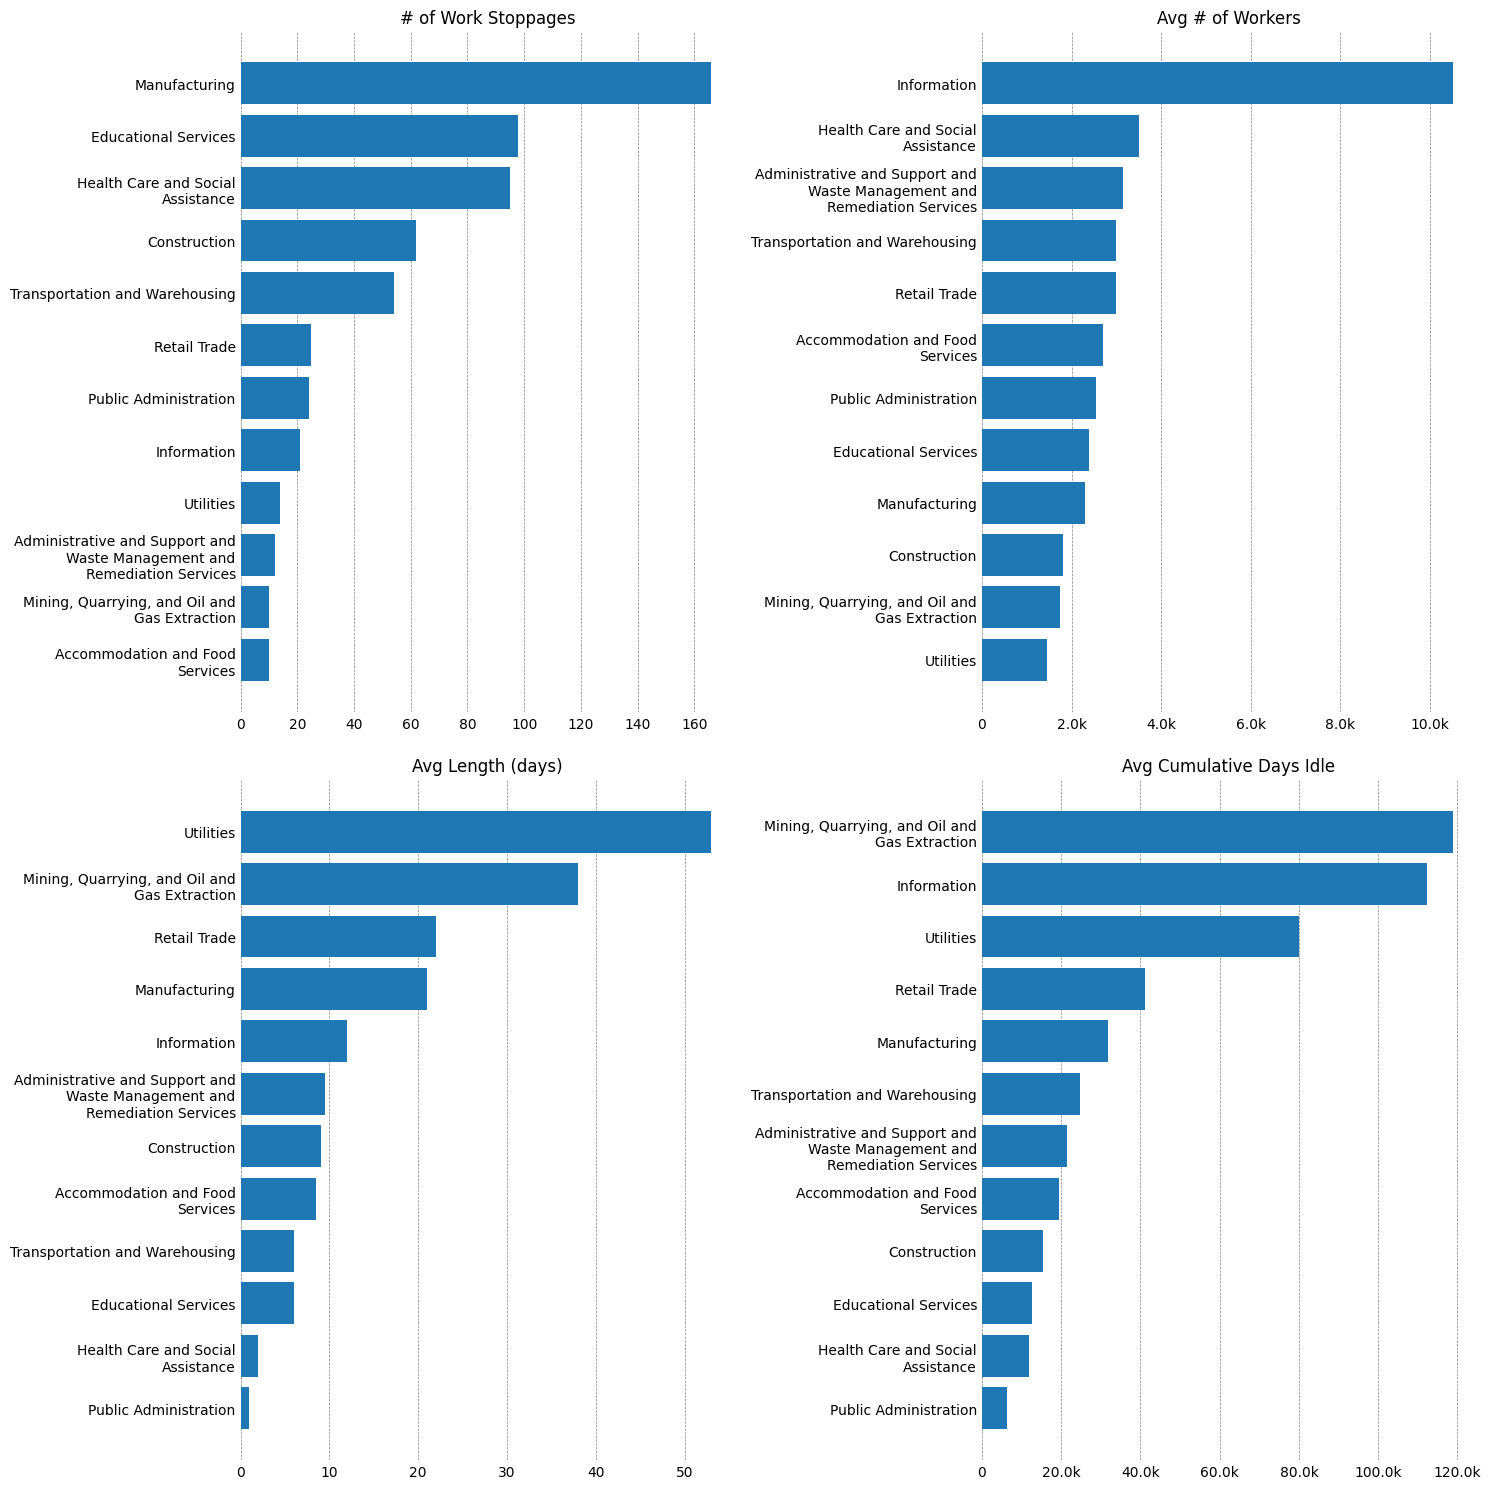

In [26]:
# Filter out industries with fewer than 10 work stoppages in thirty years.
grouped_by_industry = grouped_by_industry[grouped_by_industry['Number of work stoppages'] >= 10]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

num = 100

grouped_by_industry['Industry'] = grouped_by_industry['Industry'].apply(lambda x: '\n'.join(wrap(x, 30)))

df_sorted = grouped_by_industry.sort_values(by='Number of work stoppages', ascending=True).tail(num)
ax1.barh(df_sorted['Industry'], df_sorted['Number of work stoppages'])
ax1.set_title('# of Work Stoppages')

df_sorted = grouped_by_industry.sort_values(by='Number of workers median', ascending=True).tail(num)
ax2.barh(df_sorted['Industry'], df_sorted['Number of workers median'])
ax2.set_title('Avg # of Workers')
ax2.xaxis.set_major_formatter(format_k_label)

df_sorted = grouped_by_industry.sort_values(by='Length (days) median', ascending=True).tail(num)
ax3.barh(df_sorted['Industry'], df_sorted['Length (days) median'])
ax3.set_title('Avg Length (days)')

df_sorted = grouped_by_industry.sort_values(by='Cumulative days idle median', ascending=True).tail(num)
ax4.barh(df_sorted['Industry'], df_sorted['Cumulative days idle median'])
ax4.set_title('Avg Cumulative Days Idle')
ax4.xaxis.set_major_formatter(format_k_label)

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_axisbelow(True)  # Ensure gridlines are below other elements

    # Remove all borders except the grid
    ax.spines['top'].set_visible(False)    # Remove the top spine
    ax.spines['right'].set_visible(False)  # Remove the right spine
    ax.spines['left'].set_visible(False)   # Remove the left spine
    ax.spines['bottom'].set_visible(False) # Optionally, remove the bottom spine if no x-axis is needed

    ax.grid(axis='x', color='gray', linestyle='--', linewidth=0.5)

    # Remove tick marks but keep the labels
    ax.tick_params(axis='both', which='both', length=0)  # Set 'length' to 0 to remove ticks

fig.set_figwidth(15)
fig.set_figheight(15)
fig.tight_layout()
fig.subplots_adjust(wspace=0.5,hspace=0.1)
fig.show()

### Analysis 

This graph really highlights the relationship between the frequency, size, and duration of work stoppages and their overall impact (as measured by cumulative days idle). Some industries, like Information have a high impact because they have large numbers of of workers behind them. Others, like Mining, are because their work stoppages last a long time.

## By Year

The first variable I want to look at is year. How have the frequency, size, and length of work stoppages changed over time? Do external political factors, like whih party occupies the White House, have any relevance? We'll want to aggregate our data based on year, but there's one anomaly we'll want to remove first. Nearly every work stoppage in the data set began in 1993 or later, the same year BLS started collecting data. There's one, though, that began all the way back in 1988 that's included here because it didn't end until 1993. Since we're using the the beginning year of the work stoppage here, and this dataset does not include any other work stoppages that began 1988-1992, we will exclude that anomalous work stoppage.

In [27]:

grouped_by_year = bls_dataframe[bls_dataframe['Year'] >= 1993].groupby(['Year']).agg({
    'Number of workers': ['mean', 'count'],
    'Cumulative days idle': 'mean',
    'Length (days)': 'mean'
}).reset_index(names=['Year'])

grouped_by_year.columns = grouped_by_year.columns.map(' '.join)
grouped_by_year = grouped_by_year.rename(columns={'Year ' : 'Year', 'Number of workers count' : 'Number of work stoppages'})
grouped_by_year.head()


,Year,Number of workers mean,Number of work stoppages,Cumulative days idle mean,Length (days) mean
0,1993,5197.142857,35,102794.285714,28.171429
1,1994,7211.111111,45,176624.444444,39.844444
2,1995,6343.333333,30,115896.666667,33.833333
3,1996,7370.270270,37,141786.486486,39.945946
4,1997,11675.862069,29,121651.724138,18.586207


### Graph

C:\Users\emmaf\AppData\Local\Temp\ipykernel_23676\4009767662.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


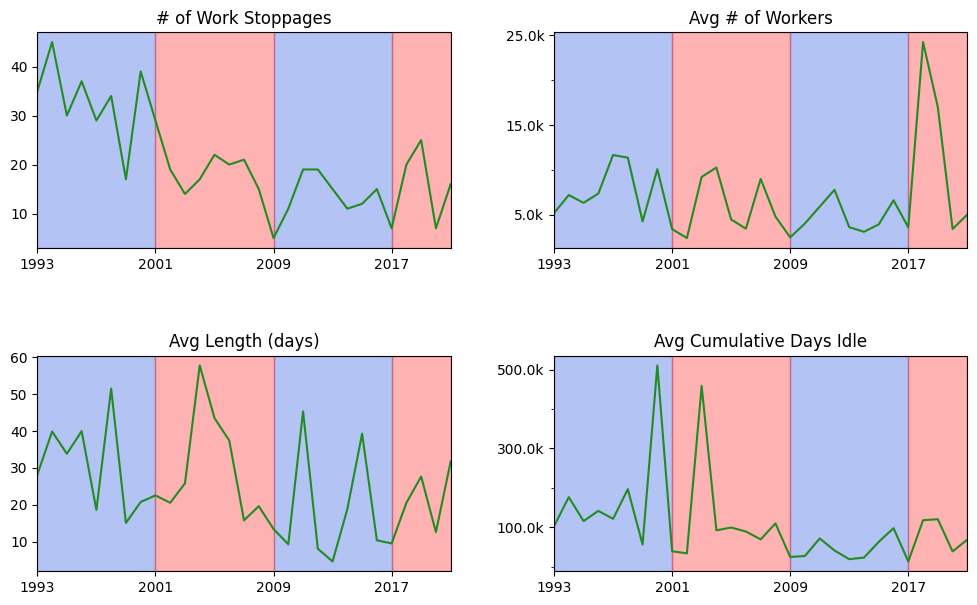

In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.plot(grouped_by_year['Year'], grouped_by_year['Number of work stoppages'], color='forestgreen')
ax1.set_title('# of Work Stoppages')

ax2.plot(grouped_by_year['Year'], grouped_by_year['Number of workers mean'], color='forestgreen')
ax2.set_title('Avg # of Workers')

ax2.yaxis.set_major_locator(ticker.FixedLocator([5000,15000,25000]))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(5000))
ax2.yaxis.set_major_formatter(format_k_label)

ax3.plot(grouped_by_year['Year'], grouped_by_year['Length (days) mean'], color='forestgreen')
ax3.set_title('Avg Length (days)')
ax3.yaxis.set_minor_locator(ticker.MultipleLocator(20))
ax3.yaxis.set_minor_locator(ticker.MultipleLocator(10))

ax4.plot(grouped_by_year['Year'], grouped_by_year['Cumulative days idle mean'], color='forestgreen')
ax4.set_title('Avg Cumulative Days Idle')
ax4.yaxis.set_major_locator(ticker.FixedLocator([100000,300000,500000]))
ax4.yaxis.set_minor_locator(ticker.MultipleLocator(100000))
ax4.yaxis.set_major_formatter(format_k_label)

axes = [ax1,ax2,ax3,ax4]
for ax in axes:
    ax.set_xlim([1993,2021])
    # ax.set_xlabel('Year')
    
    ax.set_xticks([1993,2001,2009,2017])
    # years with a Democratic president are shaded in blue
    ax.axvspan(1993, 2001, alpha=0.4, color='royalblue')
    ax.axvspan(2009, 2017, alpha=0.4, color='royalblue')

    #years with a Republican president are shaded in red
    ax.axvspan(2001, 2009, alpha=0.3, color='red')
    ax.axvspan(2017, 2021, alpha=0.3, color='red')


fig.set_figwidth(12)
fig.set_figheight(7)
fig.subplots_adjust(hspace=0.5, wspace=0.25)
fig.show()

### Analysis

As we can see, the overall frequency of work stoppages has overall been trending downward since 1993, albeit in fits and starts. The other data&emdash;the number of workers, the duration, the cumulative days idle&emdash; has been relatively constant, aside from a few spikes here and there. Thus, even if work stoppages are getting less frequent, the ones that do happen are mostly the same in terms of size and impact. The spikes are likely due to the presence of outliers in the dataset. A single work stoppage that involves multiple large unions, or one that lasts an unusually long time can willdly distort the data here.

## By Ownership Type

Let's add a new variable. What happens if we break things down by Ownership type? This dataset has four posibilities: Private industry, State government, or Local government (there's one work stoppage listed as 'State and Local government,' but we'll omit that one).

In [29]:
grouped_by_year_and_ownership = bls_dataframe[(bls_dataframe['Year'] >= 1993) & (bls_dataframe['Year'] <=2021)].groupby(['Year', 'Ownership']).agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean'],
    'Length (days)': ['mean']
}).reset_index(names=['Year', 'Ownership'])

grouped_by_year_and_ownership.columns = grouped_by_year_and_ownership.columns.map(' '.join)
grouped_by_year_and_ownership = grouped_by_year_and_ownership.rename(columns={'Ownership ' : 'Ownership', 'Year ': 'Year', 'Number of workers count' : 'Number of work stoppages'})

ownership_types = grouped_by_year_and_ownership['Ownership'].unique()
years = grouped_by_year_and_ownership['Year'].unique()

grouped_by_year_and_ownership.head(10)

C:\Users\emmaf\AppData\Local\Temp\ipykernel_23676\509332525.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_year_and_ownership = bls_dataframe[(bls_dataframe['Year'] >= 1993) & (bls_dataframe['Year'] <=2021)].groupby(['Year', 'Ownership']).agg({


,Year,Ownership,Number of workers sum,Number of workers mean,Number of work stoppages,Cumulative days idle sum,Cumulative days idle mean,Length (days) mean
0,1993,Local government,18600,3720.000000,5,104500,20900.000000,10.200000
1,1993,Private industry,161400,5565.517241,29,3485700,120196.551724,32.034483
2,1993,State and local government,0,NaN,0,0,NaN,NaN
3,1993,State government,1900,1900.000000,1,7600,7600.000000,6.000000
4,1994,Local government,22800,2850.000000,8,96600,12075.000000,5.125000
5,1994,Private industry,285900,7941.666667,36,7715000,214305.555556,48.361111
6,1994,State and local government,15800,15800.000000,1,136500,136500.000000,11.000000
7,1994,State government,0,NaN,0,0,NaN,NaN
8,1995,Local government,7100,2366.666667,3,57800,19266.666667,10.000000
9,1995,Private industry,156200,7100.000000,22,3295100,149777.272727,43.681818


### Graph

C:\Users\emmaf\AppData\Local\Temp\ipykernel_23676\937873373.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


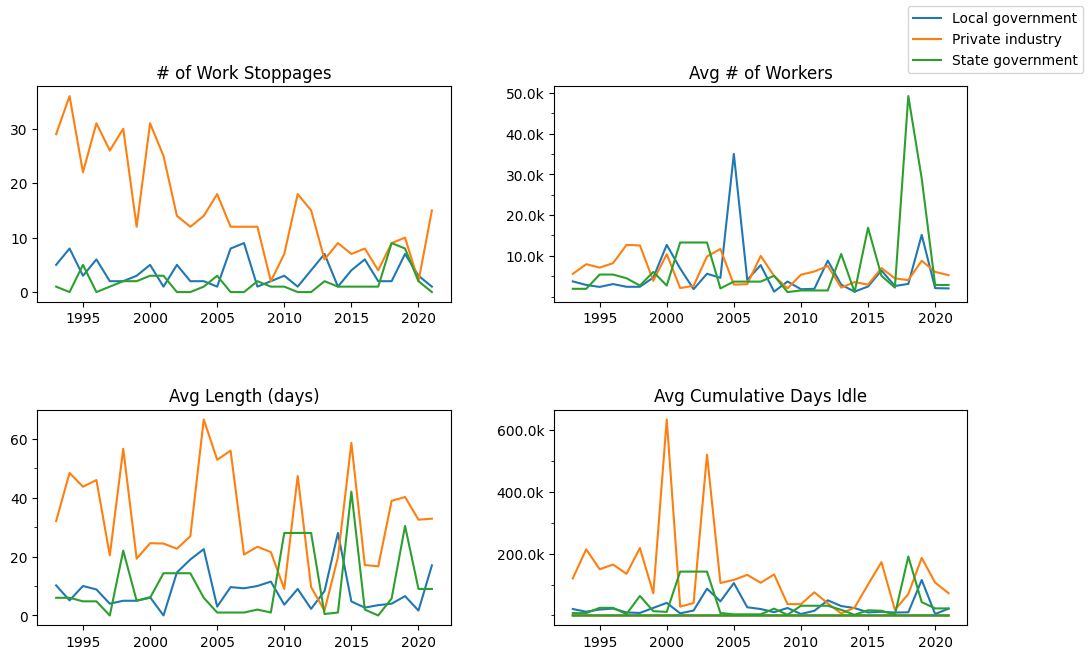

In [30]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ownership_colors = {
    "Local government": "C0",
    "Private industry": "C1",
    "State government": "C2"
}

for ownership_type in ownership_types:
    # There's only one work stoppage in the whole CSV with this ownership type, so let's omit it
    if ownership_type == "State and local government":
        continue
    ownership_data = grouped_by_year_and_ownership[grouped_by_year_and_ownership['Ownership'] == ownership_type].sort_values(by='Year', ascending=True)
    
    years = ownership_data['Year']
    num_work_stoppages = ownership_data['Number of work stoppages']

    ax1.plot(ownership_data['Year'].ffill(), ownership_data['Number of work stoppages'].ffill())
    ax1.set_title('# of Work Stoppages')

    ax2.plot(ownership_data['Year'].ffill(), ownership_data['Number of workers mean'].ffill(), color=ownership_colors[ownership_type])
    ax2.set_title('Avg # of Workers')
    ax2.yaxis.set_major_locator(ticker.FixedLocator([10000,20000,30000,40000,50000]))
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(5000))
    ax2.yaxis.set_major_formatter(format_k_label)

    ax3.plot(ownership_data['Year'].ffill(), ownership_data['Length (days) mean'].ffill(), color=ownership_colors[ownership_type])
    ax3.set_title('Avg Length (days)')
    ax3.yaxis.set_minor_locator(ticker.MultipleLocator(20))
    ax3.yaxis.set_minor_locator(ticker.MultipleLocator(10))

    ax4.plot(ownership_data['Year'].ffill(), ownership_data['Cumulative days idle mean'].ffill(), color=ownership_colors[ownership_type])
    ax4.set_title('Avg Cumulative Days Idle')
    ax4.yaxis.set_major_locator(ticker.FixedLocator([200000,400000,600000]))
    ax4.yaxis.set_minor_locator(ticker.MultipleLocator(100000))
    ax4.yaxis.set_major_formatter(format_k_label)

    plt.plot(pd.Series(years), num_work_stoppages, label=ownership_type)

fig.set_figwidth(12)
fig.set_figheight(7)
fig.subplots_adjust(hspace=0.5, wspace=0.25)
fig.legend()
fig.show()

### Analysis
 
It seems that the overall decline in the frequency of work stoppages can be ascribed almost entirely to the private sector. Public sector unions, be they state or local, seem to have remained more or less constant in terms of how frequently they work stoppage (i.e.: not very freuqently). Whether this is because private sector unions are going on work stoppage less frequently, or because the private sector has become less unionized overall, it's hard to say. It also seems like private sector work stoppages tend to last somewhat longer, but don't necessarily involve more workers.

## Conclusion
The main take away from this is that the frequency of work stoppages in the private sector has been declining steadily for the past thirty years, primarily in the private sector. It would be interesting to try to determine why that might be. Is it because the US economy has switched to industries not traditionally dominated by unions? Or some other reason? It would be interesting to determine.